In [1]:
from mmml import *

In [2]:
import sys
import argparse
from pathlib import Path
import numpy as np
from typing import Dict

# Add mmml to path
# repo_root = Path(__file__).parent / "../../.."
repo_root = Path("/scicore/home/meuwly/boitti0000/mmml")
sys.path.insert(0, str(repo_root.resolve()))

import jax
import jax.numpy as jnp
from mmml.data import load_npz, DataConfig
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model
from mmml.physnetjax.physnetjax.directories import BASE_CKPT_DIR


def ensure_standard_keys(data: Dict, verbose: bool = False) -> Dict:
    """
    Ensure data dictionary has standard keys expected by PhysNetJax.
    
    PhysNetJax expects:
    - 'D' for dipoles (from 'Dxyz'), shape (n_structures, 3)
    - Standard energy/force keys
    """
    out = data.copy()
    
    # Handle dipole keys - check both D and Dxyz
    dipole_array = None
    dipole_key = None
    if 'D' in data:
        dipole_array = data['D']
        dipole_key = 'D'
    elif 'Dxyz' in data:
        dipole_array = data['Dxyz']
        dipole_key = 'Dxyz'
    
    if dipole_array is not None:
        # PhysNetJax expects dipoles as (n_structures, 3)
        if dipole_array.ndim == 2:
            if dipole_array.shape[1] == 3:
                # Already correct shape (n_structures, 3)
                out['D'] = dipole_array
            else:
                # Wrong second dimension - might be (n_structures, n_atoms) incorrectly!
                # This can happen if dipoles were padded like atom coordinates
                if verbose:
                    print(f"  ⚠️  WARNING: {dipole_key} has shape {dipole_array.shape}")
                    print(f"  ⚠️  Expected (n_structures, 3), got second dim = {dipole_array.shape[1]}")
                    print(f"  ⚠️  Will extract first 3 columns as dipole moment...")
                # Take first 3 columns assuming they are x, y, z components
                out['D'] = dipole_array[:, :3].copy()
        elif dipole_array.ndim == 3:
            # Shape is (n_structures, n_atoms, 3) - padded per-atom dipoles
            # Sum over atoms to get molecular dipole
            if verbose:
                print(f"  ⚠️  WARNING: {dipole_key} has shape {dipole_array.shape} (3D)")
                print(f"  ⚠️  Summing over atoms to get molecular dipole...")
            out['D'] = dipole_array.sum(axis=1)
        elif dipole_array.ndim == 1:
            # Flat array - reshape to (n_structures, 3)
            out['D'] = dipole_array.reshape(-1, 3)
        else:
            # Unexpected shape - keep as is and let it fail with a better error
            if verbose:
                print(f"  ⚠️  WARNING: {dipole_key} has unexpected shape {dipole_array.shape}")
            out['D'] = dipole_array
    
    return out


def resize_padded_arrays(data: Dict, target_natoms: int, verbose: bool = False) -> Dict:
    """
    Safely resize arrays that are already padded to a different num_atoms.
    
    This allows using --natoms to change the padding size of pre-padded data.
    
    Parameters
    ----------
    data : dict
        Data dictionary with potentially padded arrays
    target_natoms : int
        Target number of atoms to pad/truncate to
    verbose : bool
        Whether to print information about resizing
        
    Returns
    -------
    dict
        Data with arrays resized to target_natoms
    """
    out = data.copy()
    
    # Check if R exists to determine current padding
    if 'R' not in data or 'N' not in data:
        return out
    
    n_structures, current_natoms, _ = data['R'].shape
    
    if current_natoms == target_natoms:
        # Already correct size
        return out
    
    # Check if resizing is safe (no structure has more atoms than target)
    max_atoms = int(np.max(data['N']))
    if max_atoms > target_natoms:
        raise ValueError(
            f"Cannot resize to {target_natoms} atoms: data contains structures "
            f"with up to {max_atoms} atoms. Use --natoms >= {max_atoms}"
        )
    
    if verbose:
        print(f"\n📏 Resizing arrays from {current_natoms} to {target_natoms} atoms...")
    
    # Resize coordinate-like arrays (n_structures, n_atoms, 3)
    for key in ['R', 'F']:
        if key in data:
            old_array = data[key]
            if target_natoms > current_natoms:
                # Expand with zeros
                new_array = np.zeros((n_structures, target_natoms, 3), dtype=old_array.dtype)
                new_array[:, :current_natoms, :] = old_array
            else:
                # Truncate
                new_array = old_array[:, :target_natoms, :]
            out[key] = new_array
            if verbose:
                print(f"  {key}: {old_array.shape} → {new_array.shape}")
    
    # Resize atomic number arrays (n_structures, n_atoms)
    for key in ['Z', 'mono']:
        if key in data:
            old_array = data[key]
            if target_natoms > current_natoms:
                # Expand with zeros
                new_array = np.zeros((n_structures, target_natoms), dtype=old_array.dtype)
                new_array[:, :current_natoms] = old_array
            else:
                # Truncate
                new_array = old_array[:, :target_natoms]
            out[key] = new_array
            if verbose:
                print(f"  {key}: {old_array.shape} → {new_array.shape}")
    
    # Handle dipole array (should be n_structures, 3 - NOT padded by atoms!)
    # If D has wrong shape, fix it here
    if 'D' in data:
        dipole_array = data['D']
        if dipole_array.ndim == 2:
            if dipole_array.shape[1] == current_natoms:
                # ERROR: D was incorrectly padded with n_atoms dimension!
                # D should be (n_structures, 3), not (n_structures, n_atoms)
                # This is likely the first 3 components which are the actual dipole
                if verbose:
                    print(f"  ⚠️  WARNING: D has shape {dipole_array.shape}, expected (n_structures, 3)")
                    print(f"  ⚠️  Extracting first 3 columns as dipole moment...")
                out['D'] = dipole_array[:, :3].copy()
            elif dipole_array.shape[1] == 3:
                # Correct shape, just copy
                out['D'] = dipole_array
            else:
                # Unknown shape, keep as is
                out['D'] = dipole_array
        else:
            out['D'] = dipole_array
    
    return out


def get_args(argv=None):
    parser = argparse.ArgumentParser(
        description="Train PhysNetJax on CO2 data",
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    
    # Data arguments
    parser.add_argument(
        '--train', '--train-file',
        type=Path,
        required=True,
        help='Path to training NPZ file'
    )
    parser.add_argument(
        '--valid', '--valid-file',
        type=Path,
        required=True,
        help='Path to validation NPZ file'
    )
    
    # Model hyperparameters
    parser.add_argument('--features', type=int, default=64,
                       help='Number of features per atom')
    parser.add_argument('--max-degree', type=int, default=1,
                       help='Maximum spherical harmonic degree')
    parser.add_argument('--num-iterations', type=int, default=3,
                       help='Number of message passing iterations')
    parser.add_argument('--num-basis-functions', type=int, default=64,
                       help='Number of radial basis functions')
    parser.add_argument('--cutoff', type=float, default=6.0,
                       help='Cutoff distance in Angstroms')
    parser.add_argument('--n-res', type=int, default=3,
                       help='Number of residual blocks')
    parser.add_argument('--natoms', type=int, default=60,
                       help='Maximum number of atoms')
    parser.add_argument('--max-atomic-number', type=int, default=38,
                       help='Maximum atomic number')
    parser.add_argument('--total-charge', type=float, default=0.0,
                       help='Total molecular charge')
    
    # Training hyperparameters
    parser.add_argument('--batch-size', type=int, default=32,
                       help='Batch size')
    parser.add_argument('--epochs', '--max-epochs', type=int, default=100,
                       help='Maximum number of epochs')
    parser.add_argument('--learning-rate', '--lr', type=float, default=0.001,
                       help='Learning rate')
    parser.add_argument('--seed', type=int, default=42,
                       help='Random seed')
    
    # Loss weights
    parser.add_argument('--energy-weight', type=float, default=1.0,
                       help='Weight for energy loss')
    parser.add_argument('--forces-weight', type=float, default=50.0,
                       help='Weight for forces loss')
    parser.add_argument('--dipole-weight', type=float, default=25.0,
                       help='Weight for dipole loss')
    
    # Training options
    parser.add_argument('--restart',  type=str, default=False,
                       help='Restart from checkpoint')
    parser.add_argument('--name', type=str, default='co2_physnet',
                       help='Experiment name for checkpointing')
    parser.add_argument('--ckpt-dir', type=Path, default=None,
                       help='Checkpoint directory (default: mmml checkpoints)')
    parser.add_argument('--print-freq', type=int, default=1,
                       help='Print frequency (epochs)')
    parser.add_argument('--no-tensorboard', action='store_true',
                       help='Disable TensorBoard logging')
    parser.add_argument('--save-best', action='store_true', default=True,
                       help='Save best model')
    parser.add_argument('--objective', type=str, default='valid_forces_mae',
                       choices=['valid_forces_mae', 'valid_energy_mae', 
                               'valid_loss', 'train_forces_mae', 
                               'train_energy_mae', 'train_loss'],
                       help='Objective metric for best model selection')
    
    # Optimizer options
    parser.add_argument('--optimizer', type=str, default='amsgrad',
                       choices=['adam', 'adamw', 'amsgrad'],
                       help='Optimizer type')
    parser.add_argument('--schedule', type=str, default='warmup',
                       choices=['warmup', 'cosine_annealing', 'exponential',
                               'polynomial', 'cosine', 'warmup_cosine', 'constant'],
                       help='Learning rate schedule')
    parser.add_argument('--transform', type=str, default='reduce_on_plateau',
                       help='Learning rate transform')
    
    # Advanced options
    parser.add_argument('--zbl', action='store_true', default=False,
                       help='Use ZBL repulsion')
    parser.add_argument('--charges', action='store_true',
                       help='Predict atomic charges')
    parser.add_argument('--no-energy-bias', action='store_true',
                       help='Disable learnable per-element atomic energy bias (useful when energies already have atomic references subtracted)')
    parser.add_argument('--center-coordinates', action='store_true',
                       help='Center coordinates at origin')
    parser.add_argument('--normalize-energy', action='store_true',
                       help='Normalize energies')
    
    # Energy preprocessing options
    parser.add_argument('--energy-unit', type=str, default='eV',
                       choices=['eV', 'hartree', 'kcal/mol', 'kJ/mol'],
                       help='Energy unit in the input data')
    parser.add_argument('--convert-energy-to', type=str, default=None,
                       choices=['eV', 'hartree', 'kcal/mol', 'kJ/mol'],
                       help='Convert energies to this unit (default: no conversion)')
    parser.add_argument('--subtract-atomic-energies', action='store_true',
                       help='Subtract atomic energy references from molecular energies')
    parser.add_argument('--atomic-energy-method', type=str, default='linear_regression',
                       choices=['linear_regression', 'mean', 'default'],
                       help='Method for computing atomic energy references: '
                            'linear_regression (fit from data), mean (average per atom), '
                            'default (use predefined PhysNetJax reference energies)')
    parser.add_argument('--scale-by-atoms', action='store_true',
                       help='Scale energies by number of atoms (per-atom energies)')
    
    parser.add_argument('--verbose', action='store_true', default=True,
                       help='Verbose output')
    
    args = parser.parse_args(argv)


    return args

def main(args):
    print("="*70)
    print("="*70)
    
    # Validate input files
    if not args.train.exists():
        print(f"❌ Error: Training file not found: {args.train}")
        sys.exit(1)
    
    if not args.valid.exists():
        print(f"❌ Error: Validation file not found: {args.valid}")
        sys.exit(1)
    
    print(f"\n📁 Data Files:")
    print(f"  Train: {args.train}")
    print(f"  Valid: {args.valid}")
    
    # Setup checkpoint directory
    if args.ckpt_dir is None:
        ckpt_dir = BASE_CKPT_DIR
    else:
        ckpt_dir = args.ckpt_dir
        ckpt_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"  Checkpoints: {ckpt_dir / args.name}")
    
    # Load data
    print(f"\n{'#'*70}")
    print("# Loading Data")
    print(f"{'#'*70}")
    
    # Determine targets
    targets = ['energy', 'forces', 'dipole']
    print(f"\nTargets: {targets}")
    
    dc = DataConfig(
        batch_size=args.batch_size,
        targets=targets,
        num_atoms=args.natoms,
        center_coordinates=args.center_coordinates,
        normalize_energy=args.normalize_energy,
        energy_unit=args.energy_unit,
        convert_energy_to=args.convert_energy_to,
        subtract_atomic_energies=args.subtract_atomic_energies,
        atomic_energy_method=args.atomic_energy_method,
        scale_by_atoms=args.scale_by_atoms,
        esp_mask_vdw=False,
    )
    
    # Print energy preprocessing info
    if args.verbose:
        print(f"\nEnergy preprocessing:")
        print(f"  Input unit: {args.energy_unit}")
        if args.convert_energy_to:
            print(f"  Converting to: {args.convert_energy_to}")
        if args.subtract_atomic_energies:
            print(f"  Subtracting atomic energies: {args.atomic_energy_method}")
        if args.scale_by_atoms:
            print(f"  Scaling by number of atoms: True")
        if args.normalize_energy:
            print(f"  Normalizing energies: True")
        if not any([args.convert_energy_to, args.subtract_atomic_energies, 
                    args.scale_by_atoms, args.normalize_energy]):
            print(f"  No preprocessing applied")
    
    if args.verbose:
        print(f"\nLoading training data...")
    train_raw = load_npz(args.train, config=dc, validate=True, verbose=args.verbose)
    
    # If atomic energies were computed, extract them from training metadata
    # and apply the SAME references to validation data
    atomic_energy_refs = None
    if args.subtract_atomic_energies and 'metadata' in train_raw:
        metadata = train_raw['metadata'][0] if len(train_raw['metadata']) > 0 else {}
        if 'atomic_energies' in metadata:
            atomic_energy_refs = metadata['atomic_energies']
            if args.verbose:
                print(f"\n  Atomic energies computed from training data:")
                for z, e in sorted(atomic_energy_refs.items()):
                    element_symbol = {6: 'C', 7: 'N', 8: 'O', 1: 'H'}.get(z, f'Z{z}')
                    print(f"    {element_symbol} (Z={z}): {e:.4f} eV")
    
    # Load validation data - if we have atomic energies from training, don't recompute them
    if args.verbose:
        print(f"\nLoading validation data...")
    
    if atomic_energy_refs is not None:
        # Load without computing new atomic energies
        dc_valid = DataConfig(
            batch_size=args.batch_size,
            targets=targets,
            num_atoms=args.natoms,
            center_coordinates=args.center_coordinates,
            normalize_energy=args.normalize_energy,
            energy_unit=args.energy_unit,
            convert_energy_to=args.convert_energy_to,
            subtract_atomic_energies=False,  # Don't recompute
            atomic_energy_method=args.atomic_energy_method,
            scale_by_atoms=args.scale_by_atoms,
            esp_mask_vdw=False,
        )
        valid_raw = load_npz(args.valid, config=dc_valid, validate=True, verbose=args.verbose)
        
        # Manually apply the training set's atomic energies
        if 'E' in valid_raw and 'Z' in valid_raw and 'N' in valid_raw:
            from mmml.data.preprocessing import subtract_atomic_energies
            valid_raw['E'] = subtract_atomic_energies(
                valid_raw['E'],
                valid_raw['Z'],
                valid_raw['N'],
                atomic_energy_refs
            )
            # Update metadata
            if 'metadata' not in valid_raw:
                valid_raw['metadata'] = np.array([{}], dtype=object)
            valid_metadata = valid_raw['metadata'][0] if len(valid_raw['metadata']) > 0 else {}
            valid_metadata['atomic_energies'] = atomic_energy_refs
            valid_metadata['atomic_energy_method'] = 'from_training_set'
            valid_raw['metadata'] = np.array([valid_metadata], dtype=object)
    else:
        # No atomic energy preprocessing, load normally
        valid_raw = load_npz(args.valid, config=dc, validate=True, verbose=args.verbose)
    
    # Ensure standard keys
    train_data = ensure_standard_keys(train_raw, verbose=args.verbose)
    valid_data = ensure_standard_keys(valid_raw, verbose=args.verbose)
    
    # Resize arrays if needed (allows --natoms to differ from data padding)
    train_data = resize_padded_arrays(train_data, args.natoms, verbose=args.verbose)
    valid_data = resize_padded_arrays(valid_data, args.natoms, verbose=args.verbose)
    
    # Remove metadata from training/validation data as it's not needed by the training loop
    # (and can cause issues if passed to JAX functions)
    if 'metadata' in train_data:
        del train_data['metadata']
    if 'metadata' in valid_data:
        del valid_data['metadata']
    
    print(f"\n✅ Data loaded:")
    print(f"  Training samples: {len(train_data['R'])}")
    print(f"  Validation samples: {len(valid_data['R'])}")
    print(f"  Data keys: {list(train_data.keys())}")
    print(f"  Array shapes:")
    print(f"    R: {train_data['R'].shape}")
    print(f"    Z: {train_data['Z'].shape}")
    print(f"    E: {train_data['E'].shape}")
    print(f"    F: {train_data['F'].shape}")
    if 'D' in train_data:
        print(f"    D: {train_data['D'].shape}")
    print(f"  Max atoms in data: {int(np.max(train_data['N']))}")
    
    # Check data statistics after preprocessing
    if args.verbose:
        energy_std = np.std(train_data['E'])
        force_std = np.std(train_data['F'][train_data['F'] != 0])  # Exclude padding
        print(f"\n  Energy std: {energy_std:.4f} eV")
        print(f"  Force std: {force_std:.4f} eV/Å")
    
    # Build model
    print(f"\n{'#'*70}")
    print("# Building Model")
    print(f"{'#'*70}")
    
    print(f"\nModel hyperparameters:")
    print(f"  Features: {args.features}")
    print(f"  Max degree: {args.max_degree}")
    print(f"  Message passing iterations: {args.num_iterations}")
    print(f"  Basis functions: {args.num_basis_functions}")
    print(f"  Cutoff: {args.cutoff} Å")
    print(f"  Residual blocks: {args.n_res}")
    print(f"  Max atoms: {args.natoms}")
    print(f"  ZBL repulsion: {args.zbl}")
    print(f"  Predict charges: {args.charges}")
    print(f"  Use energy bias: {not args.no_energy_bias}")
    
    model = EF(
        features=args.features,
        max_degree=args.max_degree,
        num_iterations=args.num_iterations,
        num_basis_functions=args.num_basis_functions,
        cutoff=args.cutoff,
        max_atomic_number=args.max_atomic_number,
        charges=args.charges,
        natoms=args.natoms,
        total_charge=args.total_charge,
        n_res=args.n_res,
        zbl=args.zbl,
        use_energy_bias=not args.no_energy_bias,
        debug=False,
        efa=False,
    )
    
    print(f"\n✅ Model created: PhysNetJax EF")
    
    # Training setup
    print(f"\n{'#'*70}")
    print("# Training Setup")
    print(f"{'#'*70}")
    
    print(f"\nTraining hyperparameters:")
    print(f"  Batch size: {args.batch_size}")
    print(f"  Max epochs: {args.epochs}")
    print(f"  Learning rate: {args.learning_rate}")
    print(f"  Optimizer: {args.optimizer}")
    print(f"  Schedule: {args.schedule}")
    print(f"  Transform: {args.transform}")
    print(f"  Objective: {args.objective}")
    print(f"  Random seed: {args.seed}")
    
    # Adjust loss weights if energy preprocessing changed the scale
    energy_weight = args.energy_weight
    forces_weight = args.forces_weight
    
    if args.subtract_atomic_energies or args.scale_by_atoms:
        # When preprocessing changes energy scale, we may need to adjust weights
        # Check if the energy variance increased significantly
        energy_std = np.std(train_data['E'])
        force_std = np.std(train_data['F'][train_data['F'] != 0])
        
        reference_energy_std = 1.77  # Original std for CO2 data
        if energy_std > 3 * reference_energy_std:  # If std increased significantly
            scale_factor = (reference_energy_std / energy_std) ** 2
            energy_weight = args.energy_weight * scale_factor
            
            if args.verbose:
                print(f"\n⚠️  Energy variance increased significantly after preprocessing")
                print(f"  Adjusting energy weight: {args.energy_weight:.3f} → {energy_weight:.6f}")
                print(f"  (Scale factor: {scale_factor:.6f})")
    
    print(f"\nLoss weights:")
    print(f"  Energy: {energy_weight}")
    print(f"  Forces: {forces_weight}")
    print(f"  Dipole: {args.dipole_weight}")
    
    # Initialize JAX random key
    key = jax.random.PRNGKey(args.seed)
    
    # Determine data keys for training
    data_keys = ["R", "Z", "F", "E", "N", "D", "dst_idx", "src_idx", "batch_segments"]
    
    print(f"\nData keys: {data_keys}")
    
    # Start training
    print(f"\n{'='*70}")
    print("STARTING TRAINING")
    print(f"{'='*70}\n")
    
    try:
        final_params = train_model(
            key=key,
            model=model,
            train_data=train_data,
            valid_data=valid_data,
            num_epochs=args.epochs,
            learning_rate=args.learning_rate,
            energy_weight=energy_weight,
            forces_weight=forces_weight,
            dipole_weight=args.dipole_weight,
            charges_weight=10.0,  # Not predicting charges by default
            batch_size=args.batch_size,
            num_atoms=args.natoms,
            restart=args.restart,
            print_freq=args.print_freq,
            name=args.name,
            best=args.save_best,
            optimizer=args.optimizer,
            transform=args.transform,
            schedule_fn=args.schedule,
            objective=args.objective,
            ckpt_dir=ckpt_dir,
            log_tb= False,#not args.no_tensorboard,
            batch_method='default',  # Use default batching
            batch_args_dict=None,
            data_keys=tuple(data_keys),
        )
        
        print(f"\n{'='*70}")
        print("✅ TRAINING COMPLETE!")
        print(f"{'='*70}")
        print(f"\nFinal parameters saved to: {ckpt_dir / args.name}")
        print(f"\nTo use the trained model:")
        print(f"  from mmml.physnetjax.physnetjax.models.model import EF")
        print(f"  import pickle")
        print(f"  ")
        print(f"  # Load parameters")
        print(f"  with open('{ckpt_dir / args.name / 'best_params.pkl'}', 'rb') as f:")
        print(f"      params = pickle.load(f)")
        print(f"  ")
        print(f"  # Create model and predict")
        print(f"  model = EF(...)")
        print(f"  E, F, D = model.apply(params, R, Z, ...)")
        
    except KeyboardInterrupt:
        print(f"\n\n⚠️  Training interrupted by user")
        print(f"Checkpoint saved to: {ckpt_dir / args.name}")
        sys.exit(0)
    except Exception as e:
        print(f"\n\n❌ Training failed with error:")
        print(f"  {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

In [3]:
train_model?

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs=1,
    learning_rate=0.001,
    energy_weight=1.0,
    forces_weight=52.91,
    dipole_weight=27.21,
    charges_weight=14.39,
    batch_size=1,
    num_atoms=60,
    restart=False,
    conversion={'energy': 23.060548012069496, 'forces': 23.060548012069496},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_forces_mae',
    ckpt_dir=Path('/scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/ckpts'),
    log_tb=True,
    batch_method=None,
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', 'E', 'N', 'D', 'dst_idx', 'src_idx', 'batch_segments'),
)
Docstring:
Train a PhysNetJax model with comprehensive logging and checkpointing.

This function implements the main training loop for PhysNetJax models,
including data batching, optimization, validation, checkpointing, and
TensorBoard logging. Supports both standard 

In [4]:
import matplotlib.pyplot as plt

In [5]:
# args = get_args()
repo_root
data_path = repo_root / ".." / "mitraheme.npz"
str(data_path.resolve())

'/scicore/home/meuwly/boitti0000/mitraheme.npz'

In [6]:
data_loaded = np.load(data_path)
list(data_loaded.keys())

['N', 'E', 'Q', 'D', 'Z', 'R', 'F']

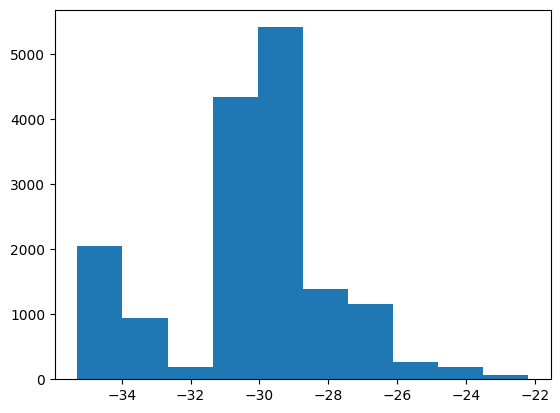

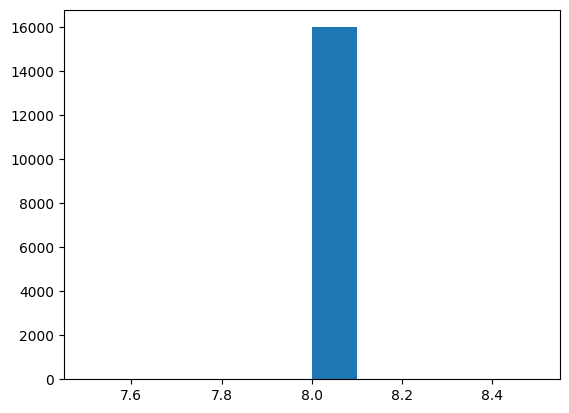

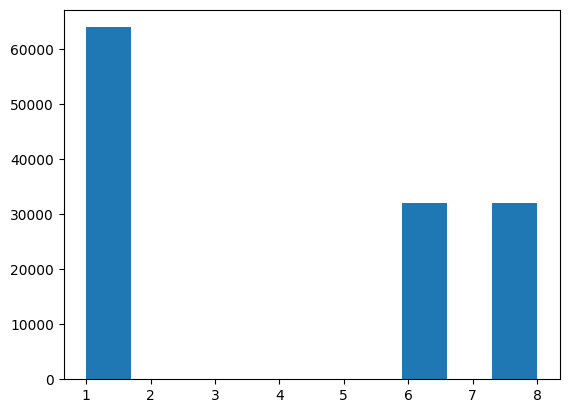

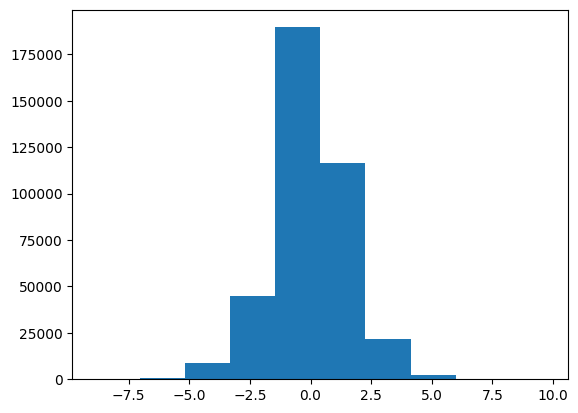

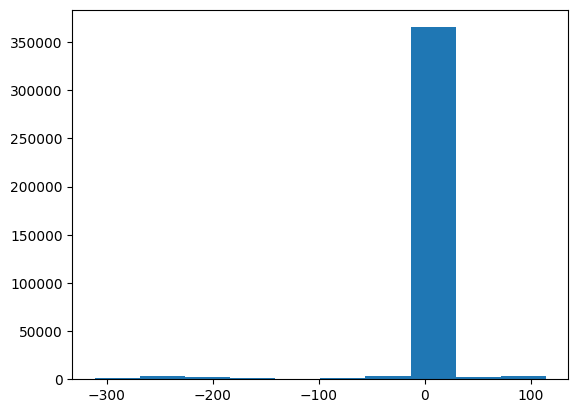

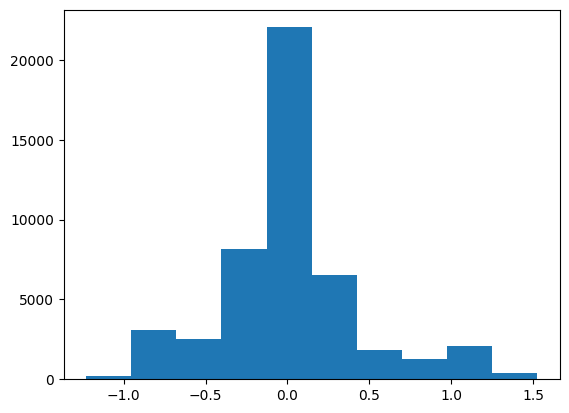

In [7]:
plt.hist(data_loaded["E"])
plt.show()
plt.hist(data_loaded["N"])
plt.show()
plt.hist(data_loaded["Z"].flatten())
plt.show()
plt.hist(data_loaded["F"].flatten())
plt.show()
plt.hist(data_loaded["R"].flatten())
plt.show()
plt.hist(data_loaded["D"].flatten())
plt.show()

In [14]:
# python -m mmml.cli.split_dataset     --efd ~/mitraheme.npz     -o splits/     --train 0.8 --valid 0.1 --test 0.1     --seed 42

In [8]:
test_data = Path(".") / "splits" / "energies_forces_dipoles_test.npz"
train_data = Path(".") / "splits" / "energies_forces_dipoles_train.npz"
val_data = Path(".") / "splits" / "energies_forces_dipoles_valid.npz"


In [9]:
import os


In [12]:
args = get_args([
    "--train", str(train_data.resolve()),
    "--valid", str(val_data.resolve()),
    "--epochs", "5000",
    "--batch-size", "1000",
    "--ckpt-dir", "{}".format(Path(os.path.curdir).resolve()),
    "--charges", "--schedule", "constant", "--subtract-atomic-energies", "--natoms", "8"
])

In [13]:
args


Namespace(train=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_train.npz'), valid=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_valid.npz'), features=64, max_degree=1, num_iterations=3, num_basis_functions=64, cutoff=6.0, n_res=3, natoms=8, max_atomic_number=38, total_charge=0.0, batch_size=1000, epochs=5000, learning_rate=0.001, seed=42, energy_weight=1.0, forces_weight=50.0, dipole_weight=25.0, restart=False, name='co2_physnet', ckpt_dir=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme'), print_freq=1, no_tensorboard=False, save_best=True, objective='valid_forces_mae', optimizer='amsgrad', schedule='constant', transform='reduce_on_plateau', zbl=False, charges=True, no_energy_bias=False, center_coordinates=False, normalize_energy=False, energy_unit='eV', convert_energy_to=None, subtract_atomic_energies=True, atomic_energy_method='linear_regression', scale_by_atoms=False, verbose=True)

In [14]:
# main(args)

In [15]:
checkpoint = "/scicore/home/meuwly/boitti0000/mmml/examples/heme/co2_physnet-7692022e-27c4-4a3e-8728-2cf89469badd"


In [16]:

# boitti0000@sga04:~/mmml/examples/heme$ python -m mmml.cli.convert_npz_traj ~/mitraheme.npz -o traj.traj --max-structures 100

# 🔄 Converting NPZ to trajectory...
#    Input: /scicore/home/meuwly/boitti0000/mitraheme.npz
#    Output: traj.traj
#    Structures in file: 16000
#    Stride: 1
#    Converting: 100 structures

#    Progress: 100/100

# ✅ Conversion complete!
#    Output: traj.traj
#    Structures: 100
#    File size: 0.0 MB
# boitti0000@sga04:~/mmml/examples/heme$ 





In [17]:
args = get_args([
    "--train", str(train_data.resolve()),
    "--valid", str(val_data.resolve()),
    "--epochs", "10000",
    "--energy-weight", "1",
    "--batch-size", "16",
    "--learning-rate", "0.0001",
    "--restart", checkpoint,
    "--ckpt-dir", "{}".format(Path(os.path.curdir).resolve()),
    "--charges", "--schedule", "constant", "--subtract-atomic-energies", "--natoms", "8"
])

In [18]:
args


Namespace(train=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_train.npz'), valid=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_valid.npz'), features=64, max_degree=1, num_iterations=3, num_basis_functions=64, cutoff=6.0, n_res=3, natoms=8, max_atomic_number=38, total_charge=0.0, batch_size=16, epochs=10000, learning_rate=0.0001, seed=42, energy_weight=1.0, forces_weight=50.0, dipole_weight=25.0, restart='/scicore/home/meuwly/boitti0000/mmml/examples/heme/co2_physnet-7692022e-27c4-4a3e-8728-2cf89469badd', name='co2_physnet', ckpt_dir=Path('/scicore/home/meuwly/boitti0000/mmml/examples/heme'), print_freq=1, no_tensorboard=False, save_best=True, objective='valid_forces_mae', optimizer='amsgrad', schedule='constant', transform='reduce_on_plateau', zbl=False, charges=True, no_energy_bias=False, center_coordinates=False, normalize_energy=False, energy_unit='eV', convert_energy_to=None, subtract_atomic_energie

In [ ]:
main(args)


📁 Data Files:
  Train: /scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_train.npz
  Valid: /scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_valid.npz
  Checkpoints: /scicore/home/meuwly/boitti0000/mmml/examples/heme/co2_physnet

######################################################################
# Loading Data
######################################################################

Targets: ['energy', 'forces', 'dipole']

Energy preprocessing:
  Input unit: eV
  Subtracting atomic energies: linear_regression

Loading training data...
Loaded NPZ file: /scicore/home/meuwly/boitti0000/mmml/examples/heme/splits/energies_forces_dipoles_train.npz
  Structures: 12800
  Keys: ['N', 'E', 'D', 'Z', 'R', 'F', 'metadata']

  Atomic energies computed from training data:
    H (Z=1): 600790225037.6816 eV
    C (Z=6): -600790225045.2357 eV
    O (Z=8): -600790225045.2356 eV

Loading validation data...
Loaded NPZ file: /scicore/home/

                                   Train Data                                    
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ N        ┃ E        ┃ D          ┃ Z          ┃ R             ┃ F             ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ (12800,) │ (12800,) │ (12800, 3) │ (12800, 8) │ (12800, 8, 3) │ (12800, 8, 3) │
└──────────┴──────────┴────────────┴────────────┴───────────────┴───────────────┘

                              Validation Data                              
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ N       ┃ E       ┃ D         ┃ Z         ┃ R            ┃ F            ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ (1600,) │ (1600,) │ (1600, 3) │ (1600, 8) │ (1600, 8, 3) │ (1600, 8, 3) │
└─────────┴─────────┴───────────┴───────────┴──────────────┴──────────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/data

LOGS_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax/analysis

MAIN_PATH: /scicore/home/meuwly/boitti0000/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  10:18:51

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_… ┃ scheduling… ┃ transform  ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ amsgrad   │ GradientTr… │ constant   │ <function   │ reduce_on… │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │            │ constant_s… │            │ reduce_on_… │            │     │      │       │
│           │ at          │            │ at          │            │ at          │            │     │      │       │
│           │ 0x1461241e… │            │ 0x1461241e… │            │ 0x1461197e… │            │     │      │       │
│           │ update=<fu… │            │             │            │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │            │             │            │ reduce_on_… │            │     │      │       │
│           │ at          │            │             │            │ at          │            │     │      │       │
│           │ 0x1461241e… │            │             │            │ 0x1461197e… │            │     │      │       │
└───────────┴─────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 1.0           │ 50.0          │ 25.0          │ 10.0           │ 16         │ 8         │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ restart                                   ┃ best ┃ data_keys                                 ┃ objective        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/mmml/exa… │ True │ ('R', 'Z', 'F', 'E', 'N', 'D', 'dst_idx', │ valid_forces_mae │
│                                           │      │ 'src_idx', 'batch_segments')              │                  │
└───────────────────────────────────────────┴──────┴───────────────────────────────────────────┴──────────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R        ┃ Z      ┃ F        ┃ E       ┃ N     ┃ D       ┃ dst_idx ┃ src_idx ┃ batch_ma… ┃ batch_se… ┃ atom_ma… ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ (128, 3) │ (128,) │ (128, 3) │ (16, 1) │ (16,) │ (16, 3) │ (896,)  │ (896,)  │ (896,)    │ (128,)    │ (128,)   │
└──────────┴────────┴──────────┴─────────┴───────┴─────────┴─────────┴─────────┴───────────┴───────────┴──────────┘

Extra Validation Info:
Z: Array[1600, 8] i32 n=12800 (50Kb) x∈[1, 8] μ=4.000 σ=3.082 cpu:0
R: Array[1600, 8, 3] n=38400 (0.1Mb) x∈[-302.143, 110.881] μ=-4.007 σ=35.550 cpu:0
E: Array[1600] 6.2Kb x∈[-5.071, 7.734] μ=-0.024 σ=2.498 cpu:0
N: Array[1600] i32 6.2Kb x∈[8, 8] μ=8.000 σ=0. cpu:0
F: Array[1600, 8, 3] n=38400 (0.1Mb) x∈[-7.650, 9.699] μ=-2.111e-10 σ=1.495 cpu:0
D: Array[1600, 3] n=4800 (19Kb) x∈[-1.187, 1.417] μ=0.012 σ=0.425 cpu:0


/scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 6.0   │ False │ False │ 64    │ 38    │ 1     │ 3     │ 8     │ 64     │ 3     │ 0.0    │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /scicore/home/meuwly/boitti0000/mmml/exa… │ epoch-5858 │ 5858  │ Array gpu:0 1.595 │ 2025-11-11 14:33:39.293227 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /scicore/home/meuwly/boitti0000/mmml/examples/heme/co2_physnet-7692022e-27c4-4a3e-8728-2cf89469badd/epoch-5858
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 5858, best_loss Array gpu:0 1.595


                                                                                Model Attributes                                                                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃ use_energy_bias ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 64       │ 1          │ 3              │ 64                  │ 6.0    │ 38                │ True    │ 8      │ 0.0          │ 3     │ False │ False │ False │ True            │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┴─────────────────┘

Output()

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x1461fae79980> is already entered
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-3317' coro=<_async_in_context.<locals>.run_in_context() done, defined at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-3318' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>


/scicore/home/meuwly/boitti0000/.conda/envs/mmml-gpu/lib/python3.12/site-packages/jax/_src/tree_util.py:704: 
RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  raise ValueError(f"can't tree-flatten type: {type(tree)}")
RuntimeWarning: Enable tracemalloc to get the object allocation traceback

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-3318' coro=<Kernel.shell_main() running at /scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]>
